## kNN redshift classification of galaxies by their photometry

We will use SDSS data to classify galaxies by their redshift using photometry, labels will come from spectroscopic redshifts form the same catalog.

We will start by making an SQL query to the SDSS database, where will get u,g,r,i and z bands. We will also get the spectroscopic redshift and class. In this case we have objects that are classified as galaxies and quasars, for the moment we will use both.

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from astroquery.sdss import SDSS
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [138]:
#Getting data from astropy

sdss_query = ''' SELECT TOP 100000
           p.modelMag_u, p.modelMag_g, p.modelMag_r, p.modelMag_i, p.modelMag_z,
           s.class, s.z
           FROM PhotoObjAll AS p JOIN specObjAll s ON s.bestobjid = p.objid
           WHERE p.mode = 1 AND s.sciencePrimary = 1 AND p.clean = 1 AND s.class != 'STAR'
           ORDER BY p.objid ASC
             '''
phot_z = SDSS.query_sql(sdss_query)

/home/daniela/anaconda3/envs/DSFP/lib/python3.6/site-packages/astroquery/sdss/core.py:856: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  comments='#'))


In [180]:
photo_z = phot_z.to_pandas()

In [181]:
len(photo_z.query('z <= 1')) / len(photo_z) * 100

85.962

In [140]:
photo_z

,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z,class,z
0,19.41061,18.23754,17.58132,17.20153,16.90159,b'GALAXY',0.032125
1,20.98014,20.28274,19.35493,18.85322,18.44382,b'GALAXY',0.200468
2,25.26718,22.31524,21.31751,19.93510,19.45918,b'GALAXY',0.752706
3,22.66974,22.00222,20.39819,19.57147,19.20231,b'GALAXY',0.504672
4,21.43851,18.80143,17.69470,17.19680,16.80610,b'GALAXY',0.110611
5,23.00731,21.34087,19.74872,19.14171,18.80783,b'GALAXY',0.293778
6,19.80807,18.33917,17.63962,17.24621,17.00000,b'GALAXY',0.074298
7,19.54964,17.95799,17.02898,16.53100,16.13408,b'GALAXY',0.121315
8,18.74425,17.37778,16.80538,16.51149,16.28756,b'GALAXY',0.048765
9,21.17984,19.97005,19.44376,19.11705,19.06998,b'GALAXY',0.048808


In [141]:
photo_z.shape

(100000, 7)

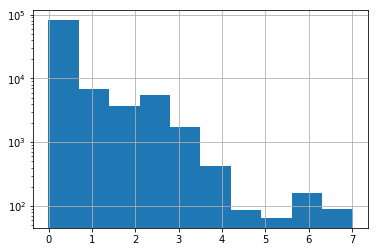

In [142]:
photo_z.z.hist()
plt.yscale('log')

In [155]:
photo_z = photo_z.query('z <= 1')

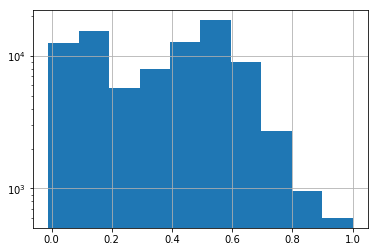

In [156]:
photo_z.z.hist()
plt.yscale('log')

In [157]:
# Separate features and classes

X = photo_z.iloc[:,:-2]
y = photo_z.z

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

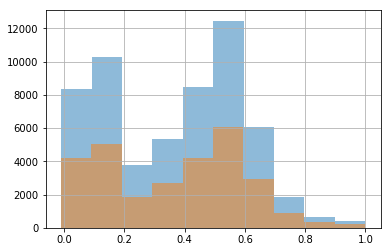

In [158]:
y_train.hist(alpha = 0.5)
y_test.hist(alpha = 0.5)

In [159]:
# Training a Regressor

knn_r = KNeighborsRegressor(n_neighbors=3)
knn_r.fit(X_train, y_train) 

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=3, p=2,
          weights='uniform')

In [160]:
# Predict

y_predict_r = knn_r.predict(X_test)

In [165]:
list(X_test)

['modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i', 'modelMag_z']

In [174]:
X_train.modelMag_z.min()

-9999.0

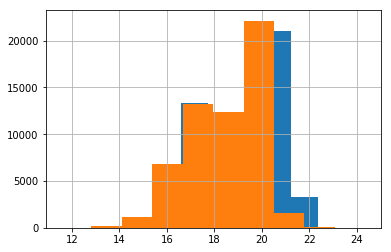

In [175]:
#X_train.modelMag_u.hist(bins = 100)
#X_train.modelMag_g.hist()
X_train.modelMag_r.hist()
X_train.modelMag_i.hist()
#X_train.modelMag_z.hist()

[]

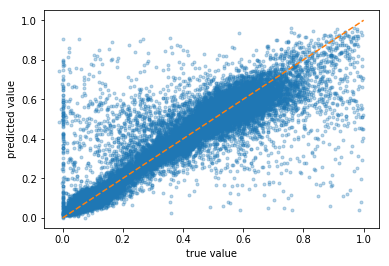

In [164]:
plt.scatter(y_test, y_predict_r, color = X_test.modelMag_r)
plt.plot([0,1],[0,1], '--')
plt.xlabel('true value')
plt.ylabel('predicted value')
plt.plot()

/home/daniela/anaconda3/envs/DSFP/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


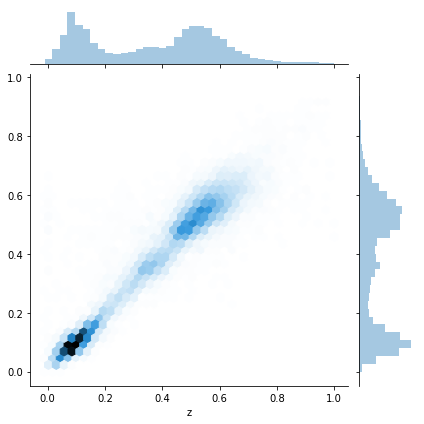

In [182]:
sns.jointplot(y_test, y_predict_r, kind="hex")
plt.savefig('fig.png')

In [163]:
mean_squared_error(y_test, y_predict_r)

0.008338239288860858

In [132]:
# Optimizing number of neighbors based on mean squared error

def get_acc(k, X_train, y_train, X_test, y_test):
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train) 
    y_predict = knn.predict(X_test)
    
    return mean_squared_error(y_test, y_predict)

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.33, random_state=42)

neighbors = np.arange(2,40,1)
accuracy = []
for n in neighbors:
    accuracy.append(get_acc(n, X_tr, y_tr, X_te, y_te))

The optimal number of neighbors is 10


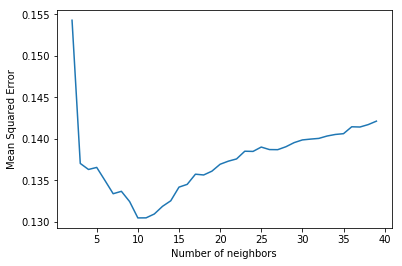

In [135]:
# Plot results from tuning

plt.plot(neighbors, accuracy)
plt.xlabel('Number of neighbors')
plt.ylabel('Mean Squared Error')
print('The optimal number of neighbors is {}'.format(neighbors[np.argmin(accuracy)]))

Mean Squared Error is 0.1304825465846894


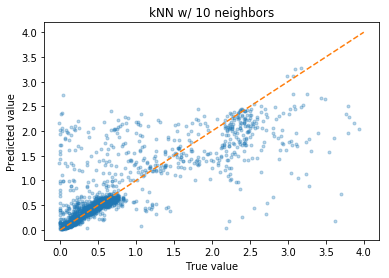

In [183]:
# Re-run for the optimal

knn10 = KNeighborsRegressor(n_neighbors=10)
knn10.fit(X_tr, y_tr) 
y_pr = knn10.predict(X_te)
mse = mean_squared_error(y_te, y_pr)


plt.plot(y_te, y_pr, '.', alpha = 0.3)
plt.plot([0,4],[0,4], '--')
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.title('kNN w/ 10 neighbors')
plt.plot()
print('Mean Squared Error is {}'.format(mse))
plt.savefig('fig2.png')

In [102]:
# Test on 3DHST data

new_cat = pd.read_csv('/home/daniela/Magister/datos/goodss_3dhst.v4.1.cats/Catalog/goodss_3dhst.v4.1.cat',
                      delim_whitespace= True, comment = '#')
new_z = pd.read_csv('/home/daniela/Magister/datos/goodss_3dhst.v4.1.cats/Eazy/goodss_3dhst.v4.1.zout',
                      delim_whitespace= True, comment = '#')

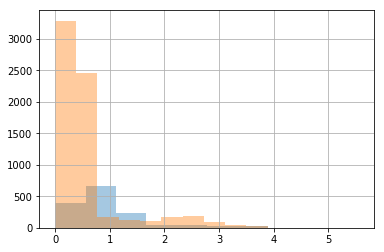

In [119]:
new_z.query('z_spec >= 0').z_spec.hist(alpha = 0.4)
y_train.hist(alpha = 0.4)

In [117]:
z_spec = new_z.query('z_spec >= 0')
cat_zspec = new_cat[new_cat.id.isin(z_spec.id)]
z_spec = z_spec.z_spec

In [118]:
len(cat_zspec), len(z_spec)

(1445, 1445)

In [121]:
list(cat_zspec)[5:-26]

['faper_F160W',
 'eaper_F160W',
 'faper_F140W',
 'eaper_F140W',
 'f_F160W',
 'e_F160W',
 'w_F160W',
 'f_U38',
 'e_U38',
 'w_U38',
 'f_U',
 'e_U',
 'w_U',
 'f_F435W',
 'e_F435W',
 'w_F435W',
 'f_B',
 'e_B',
 'w_B',
 'f_V',
 'e_V',
 'w_V',
 'f_F606Wcand',
 'e_F606Wcand',
 'w_F606Wcand',
 'f_F606W',
 'e_F606W',
 'w_F606W',
 'f_R',
 'e_R',
 'w_R',
 'f_Rc',
 'e_Rc',
 'w_Rc',
 'f_F775W',
 'e_F775W',
 'w_F775W',
 'f_I',
 'e_I',
 'w_I',
 'f_F814Wcand',
 'e_F814Wcand',
 'w_F814Wcand',
 'f_F850LP',
 'e_F850LP',
 'w_F850LP',
 'f_F850LPcand',
 'e_F850LPcand',
 'w_F850LPcand',
 'f_F125W',
 'e_F125W',
 'w_F125W',
 'f_J',
 'e_J',
 'w_J',
 'f_tenisJ',
 'e_tenisJ',
 'w_tenisJ',
 'f_F140W',
 'e_F140W',
 'w_F140W',
 'f_H',
 'e_H',
 'w_H',
 'f_tenisK',
 'e_tenisK',
 'w_tenisK',
 'f_Ks',
 'e_Ks',
 'w_Ks',
 'f_IRAC1',
 'e_IRAC1',
 'w_IRAC1',
 'f_IRAC2',
 'e_IRAC2',
 'w_IRAC2',
 'f_IRAC3',
 'e_IRAC3',
 'w_IRAC3',
 'f_IRAC4',
 'e_IRAC4',
 'w_IRAC4',
 'f_IA427',
 'e_IA427',
 'f_IA445',
 'e_IA445',
 'f_IA505',


In [ ]:
cat = cat_zspec.iloc[:,]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(c, y, test_size=0.33, random_state=42)